# Chapter 4: 

# Text Analytics

Nội dung chương này tương ứng với chương 20 của cuốn [Data mining for business analytics: concepts, techniques, and applications in R](https://www.wiley.com/en-us/Data+Mining+for+Business+Analytics%3A+Concepts%2C+Techniques%2C+and+Applications+in+R-p-9781118879368). Text Analytics là một mảng quan trọng của Data Science và có nhiều ứng dụng. Một trong những ứng dụng đó là: (1) phân loại tin nhắn rác, (2) phân tích cảm xúc. 

Bài toán phân loại tin nhắn rác có thể tìm hiểu kĩ hơn về Viettel Anti Spam [ở đây](http://4gviettel.info/viettel-anti-spam/). Chương này hướng dẫn trước hết là các kĩ thuật xử lí dữ liệu text cho các thuật toán ML như tác từ (Tokenization), chuyển hóa scopus về ma trận thưa (Sparse Matrix). Chương 20 cuốn *Data mining for business analytics: concepts, techniques, and applications in R* mô tả rất chi tiết và trực quan về những khái niệm cơ bản này của Text Analytics. Kế tiếp là thực hành áp dụngRandom Forest để xây dựng một engine phân loại tin nhắn rác tương tự như sản phẩm của Viettel. Dữ liệu thực hành là *sms_spam.csv* và có thể lấy [ở đây](http://www.mediafire.com/file/3lg8bsfbu6csq8d/KinhTeLuongUngDungVoiR.rar/file). 

In [1]:
# Load một số gói: 
import pandas as pd
import numpy as np

# Đọc dữ liệu: 
message = pd.read_csv('C:/Users/Zbook/Documents/sms_spam.csv', encoding='latin-1', names=["labels", "message"])

# Bỏ qua dòng đầu tiên: 
message = message[1:]

# Xem qua dữ liệu: 
message.head()

,labels,message
1,ham,Hope you are having a good week. Just checking in
2,ham,K..give back my thanks.
3,ham,Am also doing in cbe only. But have to pay.
4,spam,"complimentary 4 STAR Ibiza Holiday or Â£10,000..."
5,spam,okmail: Dear Dave this is your final notice to...


In [2]:
# Convert về 1 cho spam và 0 cho ham: 
message['labels'] = message['labels'].map({'ham': 0, 'spam': 1})

# Rồi xem lại dữ liệu: 
message.head()

,labels,message
1,0,Hope you are having a good week. Just checking in
2,0,K..give back my thanks.
3,0,Am also doing in cbe only. But have to pay.
4,1,"complimentary 4 STAR Ibiza Holiday or Â£10,000..."
5,1,okmail: Dear Dave this is your final notice to...


Chúng ta có thể xem với tin nhắn rác thì những từ nào xuất hiện nhiều nhất bằng công cụ hình ảnh là word cloud như sau: 

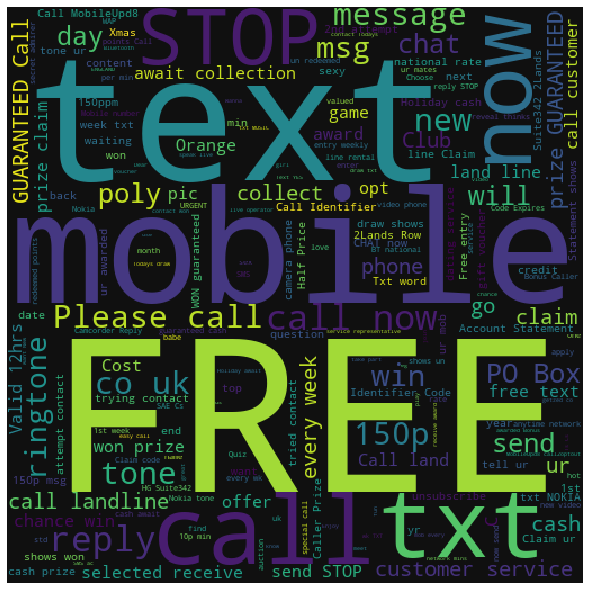

In [3]:
# Load các packages cần thiết cho hình ảnh hóa words cloud: 
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Những từ xuất hiện nhiều nhất (căn cứ vào kích thước) đối với các tin nhắn rác: 
spam_words = ''.join(list(message[message['labels'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512, background_color="#101010").generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'none')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)

Để áp dụng các mô hình ML cho dữ liệu text trước hết chúng ta cần thực hai bước "sơ chế" quan trọng là Tokenization, chuyển hóa scopus về ma trận thưa (Sparse Matrix). Dưới đây là Python codes: 

In [4]:
# Load một số gói cho xử lí dữ liệu text: 
# import nltk
# nltk.download('stopwords')

import string
from nltk.corpus import stopwords

# Viết hàm xử lí text (bỏ dấu chấm câu, stopwords trong tiếng Anh): 
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [7]:
# Thực hiện Tokenization + convert dữ liệu text về Sparse Matrix: 
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(message['message'])
messages_bow = bow_transformer.transform(message['message'])

In [8]:
# Thực hiện Term Frequency–Inverse Document Frequency (TF-IDF): 
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)

Thực hiện phân chia dữ liệu: 

In [25]:
# Thực hiện phân chia dữ liệu với 70% cho training, 30% cho testing: 
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(message['message'],
                                                                message['labels'],
                                                                test_size=0.3, 
                                                                random_state = 29,
                                                                shuffle = True)

Huấn luyện Random Forest và thực hiện dự báo: 

In [26]:
# Thiết lập các tham số cho huấn luyện Random Forest (RF):

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(criterion='gini', 
                                          n_estimators=500,
                                          min_samples_split=10,
                                          min_samples_leaf=1,
                                          max_features='auto',
                                          oob_score=True,
                                          random_state=1,
                                          n_jobs=-1))
])

# Huấn luyện RF: 
pipeline.fit(msg_train, label_train)

# Thực hiện dự báo: 
predictions = pipeline.predict(msg_test)

Đánh giá chất lượng dự báo của RF với bộ dữ liệu test: 

In [27]:
# Đánh giá chất lượng dự báo của RF. Trước hết là ma trận nhầm lẫn: 

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_test, predictions)
print(cm)

[[1426    0]
 [  49  193]]


In [28]:
# RF dự báo chính xác 79.75% tin nhắn rác trong tổng số tin nhắn rác thực tế. 
# Nói cách khác RF phân loại đúng 193 tin nhắn rác trong tổng số 194 + 49 = 243: 

from sklearn.metrics import recall_score
recall_score(label_test, predictions)

0.7975206611570248

Ngoài Recall chúng ta cũng có thể đánh giá chất lượng dự báo của mô hình qua một số tiêu chí khác như sau: 

In [31]:
from sklearn.metrics import classification_report
report = classification_report(label_test, predictions)
print("Results:", report)

Results:               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1426
           1       1.00      0.80      0.89       242

    accuracy                           0.97      1668
   macro avg       0.98      0.90      0.94      1668
weighted avg       0.97      0.97      0.97      1668



# Final Notes

- Việc xử lí dữ liệu text cho tiếng Việt có thể cần phải điều chỉnh. Tiếng Anh thì mỗi một từ đơn nhất sẽ tương ứng với một (hoặc tập hợp) nghĩa nhất định trong từ điển. Nhưng với tiếng Việt thì hơi khác. Ví dụ từ "tổ quốc" chúng ta không thể tách từ này thành hai cụm là "tổ" và "quốc" khi làm Tokenization. Do vậy khi xử lí tiếng Việt cần có thêm một bước là "so từ". 

- Chúng ta có thể điều chỉnh ngưỡng sao cho tăng mức độ dự báo tin nhắn rác. Có thể tham khảo việc điều chỉnh ngưỡng [ở đây](http://rpubs.com/chidungkt/516382) và [ở đây](https://github.com/ChiDungNguyen/Chapter3_Tieu_Chi_Danh_Gia/blob/master/Chapter3_Performance_Metrics.ipynb). 

# Tham Khảo

1. Shmueli, G., Bruce, P. C., Yahav, I., Patel, N. R., & Lichtendahl Jr, K. C. (2017). Data mining for business analytics: concepts, techniques, and applications in R. John Wiley & Sons.
2. Sarkar, D. (2016). Text Analytics with python. Apress.
3. Bengfort, B., Bilbro, R., & Ojeda, T. (2018). Applied Text Analysis with Python: Enabling Language-aware Data Products with Machine Learning. O'Reilly Media, Inc.
4. Bird, S., Klein, E., & Loper, E. (2009). Natural language processing with Python: analyzing text with the natural language toolkit. O'Reilly Media, Inc.
5. https://www.kaggle.com/c/word2vec-nlp-tutorial
